In this lab we are going to perform fine-tuning and feature transfer for the dataset called Oxford Flowers 102. 
We will see how we can use large CNNs (VGG-16, Inception and MobileNet) already pre-trained by others on ImageNet on this dataset. We will compare results of ImageNet pretraining with just using random weights for the filters. In addition, we will perform feature transfer.

##Importing libaries
Have a look especially at Keras applications [Keras applications help](https://keras.io/api/applications/)

In [4]:
#General imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import progressbar
from __future__ import print_function
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

# Keras imports
#import keras

#from keras.preprocessing.image import load_img
#from keras.models import Sequential, Model
#from keras.optimizers import *
#from keras.utils.np_utils import to_categorical
#import keras.backend as K

# application (model) imports
#from keras import applications
#from keras.applications.inception_v3 import preprocess_input
#from keras.layers import Dense

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import *

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [ ]:
#from tensorflow.python.framework.ops import disable_eager_execution
#disable_eager_execution()

We created a new function ***network_library*** below. It will allow us to work with commonly used architectures of CNNs 

In [5]:

def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['accuracy'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

def dir_to_array(dir, image_shape, verbose=1): #this functions helps us to convert all images from a directory into a Numpy array. It also changes the size of the images.
  data = []
  labels = []
  image_shape = (image_shape[0], image_shape[1])
  if verbose ==1:
    bar = progressbar.ProgressBar(maxval=len(os.listdir(dir)),
                                  widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    i = 0
  for classname in os.listdir(dir):
    class_dir = os.path.join(dir, classname)
    for imagename in os.listdir(class_dir):
      data.append(np.array(load_img(os.path.join(class_dir, imagename), target_size=image_shape )))
      labels.append(int(classname)-1)
    if verbose == 1:
      i +=1
      bar.update(i)
  if verbose == 1:
    bar.finish()
  data = np.stack(data, axis=0)
  labels = np.expand_dims(np.stack(labels, axis=0), axis=1)
  return data, labels


def network_library(network_name, num_classes, weights='imagenet'): #Heavily uses example code from Keras 
  # Function to build keras applications 
  if network_name == 'vgg16':
    
    input_shape = (224,224,3)
    base_model = VGG16(include_top=False, weights=weights, input_shape=input_shape, pooling='max') #keep only convolutional and pooling layers, populate weights with pre-trained on ImageNet values
    preprocess_input = tf.keras.applications.vgg16.preprocess_input #function which helps with preprocessing of input images
    
    x = base_model.output
    x = layers.Dense(4096, activation='relu')(x) #Add couple of dense layers on top
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    predictions = layers.Dense(num_classes, activation='softmax')(x) #Last layer does classification into num_classes categories
    model = models.Model(inputs=base_model.input, outputs=predictions) # Model altogether
    
  elif network_name == 'inceptionv3':
    
    input_shape = (299,299,3)
    base_model = InceptionV3(include_top = False, weights=weights, input_shape=input_shape, pooling='avg')
    preprocess_input = tf.keras.applications.inception_v3.preprocess_input
    
    x = base_model.output
    x = layers.Dense(1024, activation='relu')(x) #Keras functional API
    predictions = layers.Dense(num_classes, activation='softmax')(x)
    model  = models.Model(inputs = base_model.inputs, outputs=predictions)

  elif network_name == 'mobilenetv2':
    
    input_shape = (224,224,3)
    #base_model = applications.MobileNetV2(input_shape=input_shape, alpha=1.0, include_top=False, weights=weights, pooling='avg')
    base_model = MobileNetV2(input_shape=input_shape, alpha=1.0, include_top=False, weights=weights, pooling='avg')
    #preprocess_input = applications.mobilenet_v2.preprocess_input
    preprocess_input = tf.keras.applications.mobilenet.preprocess_input
    
    x = base_model.output
    predictions = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs = base_model.input, outputs=predictions)
  else:
    raise ValueError('{} is not a supported network'.format(network_name))
  return model, input_shape, preprocess_input


In [6]:
data = tf.keras.datasets.cifar10.load_data()
#Returns
#Tuple of NumPy arrays: (x_train, y_train), (x_test, y_test).

(x_train, y_train), (x_test, y_test) = data

170500096/170498071 [==============================] - 4s 0us/step


In [7]:
print(len(x_train))

50000


In [8]:
print(type(x_train[0]))

<class 'numpy.ndarray'>


In [9]:
print(x_train[0])

[[[ 59  62  63]
  [ 43  46  45]
  [ 50  48  43]
  ...
  [158 132 108]
  [152 125 102]
  [148 124 103]]

 [[ 16  20  20]
  [  0   0   0]
  [ 18   8   0]
  ...
  [123  88  55]
  [119  83  50]
  [122  87  57]]

 [[ 25  24  21]
  [ 16   7   0]
  [ 49  27   8]
  ...
  [118  84  50]
  [120  84  50]
  [109  73  42]]

 ...

 [[208 170  96]
  [201 153  34]
  [198 161  26]
  ...
  [160 133  70]
  [ 56  31   7]
  [ 53  34  20]]

 [[180 139  96]
  [173 123  42]
  [186 144  30]
  ...
  [184 148  94]
  [ 97  62  34]
  [ 83  53  34]]

 [[177 144 116]
  [168 129  94]
  [179 142  87]
  ...
  [216 184 140]
  [151 118  84]
  [123  92  72]]]


In [10]:
print(x_train[0].shape)

(32, 32, 3)


In [3]:
!ls sample_data/   #not our stuff....

anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md


As we said before, for this lab we are going to have a look at a range of different ways of performing a classification on images using a convolutional neural network. We will be looking at the Flowers 102 dataset, a tricky dataset that is used very commonly in computer vision.

Let's download and unzip the data. The ! points here are telling the notebooks to run the commands in bash/terminal, these are not python commands.

In [ ]:
#! rm -r flower_data
#! rm flower_data.zip
#!wget "https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip" 
#!unzip -q flower_data.zip
#!ls 
#! ls flower_data

Now that we have downloaded the data, lets set the data paths so that we can find the correct data folders.

The last line is just checking that the we have the same number of test classes as we have training classes

In [ ]:
# set the data paths
train_dir = 'sample_data/'
test_dir = 'sample_data/'

#anscombe.json		      mnist_test.csv
#california_housing_test.csv   mnist_train_small.csv
#california_housing_train.csv  README.md

# (x_train, y_train), (x_test, y_test)
# ten classes

# find the number of classes
#num_classes = len(os.listdir(train_dir))


# check that the training and testing classes are the same
#assert sorted(os.listdir(train_dir)) == sorted(os.listdir(test_dir))


#print(num_classes)

Before importing the data into Python Numpy arrays let's have a look at the model we will be using.


We will be demonstrating using the [mobilenetv2 network ](https://ai.googleblog.com/2018/04/mobilenetv2-next-generation-of-on.html), but you can also select [VGG16](https://neurohive.io/en/popular-networks/vgg16/) network or[ InceptionV3](https://towardsdatascience.com/a-simple-guide-to-the-versions-of-the-inception-network-7fc52b863202) These networks are built into keras and is easy to use through the [applications toolkit](https://keras.io/applications/).

You are welcome to use a different network that is part of the applications toolkit.

Notice how deep is the network below. Have a look at the summary ouput.

In [11]:
# select which model you would like to use here
# Currently you can use mobilenetv2, inceptionv3 or vgg16
model_to_use = 'mobilenetv2'
#model_to_use = 'inceptionv3'
#model_to_use = 'vgg16'

weights= 'imagenet'

num_classes = 10

model, image_shape, preprocess_input = network_library(model_to_use, num_classes, weights=weights)

model.summary()
print(image_shape)


9412608/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________

The reason we are defining the model before we import the data is because we are going to use a specific set of weights for our model. These weights have been found by training the network on a very large dataset of general images. This large dataset is called [ImageNet](http://www.image-net.org/).

We can see above that the normal network has an input shape of (224,224,3) so in order to use the ImageNet weights we need to import each of our images at that size

Using a function defined above we can import our data from the directories to numpy arrays. While importing the data, we also rescale it. 

In [ ]:
# (x_train, y_train), (x_test, y_test)

print('Importing training data...')
train_data_all, train_labels_all = dir_to_array(train_dir, image_shape)

print('Importing testing data...')
test_data, test_labels = dir_to_array(test_dir, image_shape)



# This line is just selecting a subset of the training data to work with.
# It is done here so that training is faster, however normally you would not be dumping most of the training data!
#Taking only 0.2 of training data here
_, train_data, _, train_labels = train_test_split(train_data_all, train_labels_all, test_size=0.2, random_state=42, stratify=train_labels_all)

plt.imshow(train_data[900])

#train_data = train_data.astype('float32')/255.
#test_data = test_data.astype('float32')/255.
train_data = preprocess_input(train_data)
test_data = preprocess_input(test_data)

Importing training data...


NameError: ignored

As per usual, let's check the dimensions of our data to ensure that everything has gone smoothly and have a look at one of the images

In [ ]:
print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(1311, 224, 224, 3)
(1311, 1)
(818, 224, 224, 3)
(818, 1)


Just doing some memory tidying up

In [ ]:
import gc
gc.collect()

2875

Here, we use familiar one-hot encoding for our labels

In [ ]:
print("First 5 training labels: ", train_labels[:5]) 

y_train = to_categorical(train_labels, num_classes)
y_test = to_categorical(test_labels, num_classes)

print("First 5 training lables as one-hot encoded vectors:\n", y_train[:5])
print(y_train.shape)

First 5 training labels:  [[76]
 [43]
 [72]
 [26]
 [88]]
First 5 training lables as one-hot encoded vectors:
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

Finally, all preparations are done and we can compile our model. Please note that the data preparation normally takes a big chunk of time in data science workflow. 

Notice a small learning rate, in general we use small learning rates in fine-tuning. In summary, we compile a model here which is MobileNetv2 and with the weigths after pre-training on ImageNet

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['accuracy'])

Let's train our model!

In [ ]:
history = model.fit(train_data, y_train, batch_size=16, epochs=20, verbose=True, validation_split=.1)
loss, accuracy  = model.evaluate(test_data, y_test, verbose=False)

Epoch 1/20
74/74 [==============================] - 44s 127ms/step - loss: 4.4956 - accuracy: 0.0636 - val_loss: 4.3038 - val_accuracy: 0.1061
Epoch 2/20
74/74 [==============================] - 8s 107ms/step - loss: 2.9649 - accuracy: 0.4266 - val_loss: 3.7358 - val_accuracy: 0.2045
Epoch 3/20
74/74 [==============================] - 8s 107ms/step - loss: 1.9288 - accuracy: 0.6845 - val_loss: 3.2446 - val_accuracy: 0.2652
Epoch 4/20
74/74 [==============================] - 8s 107ms/step - loss: 1.2279 - accuracy: 0.8796 - val_loss: 2.8454 - val_accuracy: 0.3485
Epoch 5/20
74/74 [==============================] - 8s 107ms/step - loss: 0.8141 - accuracy: 0.9567 - val_loss: 2.4933 - val_accuracy: 0.4621
Epoch 6/20
74/74 [==============================] - 8s 108ms/step - loss: 0.5279 - accuracy: 0.9813 - val_loss: 2.1824 - val_accuracy: 0.5303
Epoch 7/20
74/74 [==============================] - 8s 110ms/step - loss: 0.3454 - accuracy: 0.9941 - val_loss: 1.9124 - val_accuracy: 0.5530
Epoch

And let's see the results! We do look at test set here as well. But if you compare the results of multiple settings (hyperparameter tuning) on the same dataset, you should only do in the very end!

Test loss: 0.721
Test accuracy: 0.845


<Figure size 576x432 with 0 Axes>

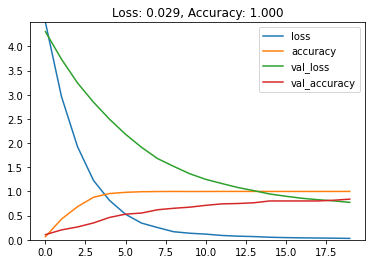

In [ ]:
plot_loss_accuracy(history)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

We can say that this particular network would benifit from further training. 

Now lets compare to training the same model using randomly initialized weights

In [ ]:

weights= None
model, image_shape, preprocess_input = network_library(model_to_use, num_classes, weights=weights)

Here we have set the weights to be None, this tells Keras that we want random weights. Let's compile and train using the same optimizer and learning rate as before. (we did not need to set the "model_to_use " again because we want to use the same model as before)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['accuracy'])

And training!

In [ ]:
history = model.fit(train_data, y_train, batch_size=16, epochs=20, verbose=True, validation_split=.1)
loss, accuracy  = model.evaluate(test_data, y_test, verbose=False)

Epoch 1/20
74/74 [==============================] - 12s 120ms/step - loss: 4.6410 - accuracy: 0.0331 - val_loss: 4.6233 - val_accuracy: 0.0076
Epoch 2/20
74/74 [==============================] - 8s 111ms/step - loss: 4.3986 - accuracy: 0.0509 - val_loss: 4.6190 - val_accuracy: 0.0076
Epoch 3/20
74/74 [==============================] - 8s 113ms/step - loss: 4.2869 - accuracy: 0.0687 - val_loss: 4.6128 - val_accuracy: 0.0076
Epoch 4/20
74/74 [==============================] - 8s 114ms/step - loss: 4.1987 - accuracy: 0.0729 - val_loss: 4.6064 - val_accuracy: 0.0076
Epoch 5/20
74/74 [==============================] - 8s 112ms/step - loss: 4.0961 - accuracy: 0.0899 - val_loss: 4.6006 - val_accuracy: 0.0076
Epoch 6/20
74/74 [==============================] - 8s 110ms/step - loss: 3.9373 - accuracy: 0.1196 - val_loss: 4.5974 - val_accuracy: 0.0076
Epoch 7/20
74/74 [==============================] - 8s 110ms/step - loss: 3.8525 - accuracy: 0.1128 - val_loss: 4.5920 - val_accuracy: 0.0076
Epoch

Test loss: 4.67
Test accuracy: 0.0342


<Figure size 576x432 with 0 Axes>

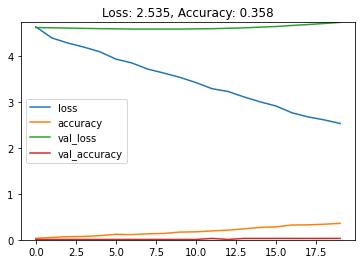

In [ ]:
plot_loss_accuracy(history)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

This model initilised from random weights takes much much longer to start learning. 

The difference between these models is that one has weights that are known to work well for general image recognition. 
Using these "good weights" means our network starts with some prior knowledge taken from some other task. This is so called **fine-tuning**.

Next, let's have a look at **transfer learning** where we **do not** need to conduct a long CNN training run at all.

First we initialize a model using the pre-trained weights we had before

In [ ]:
#model_to_use ='mobilenetv2' # change the model here if you like
model_to_use = 'inceptionv3'
#model_to_use = 'vgg16'

def build_extraction_model(model_to_use):
  if model_to_use == 'vgg16':
    extraction_model = VGG16(include_top=False, weights='imagenet', input_shape=image_shape, pooling='max')
  elif model_to_use == 'inceptionv3':
    extraction_model = InceptionV3(include_top = False, weights='imagenet', input_shape=image_shape, pooling='avg')
  elif model_to_use == 'mobilenetv2':
    extraction_model = MobileNetV2(input_shape=image_shape, alpha=1.0, include_top=False, weights='imagenet', pooling='avg')
  return extraction_model



extraction_model = build_extraction_model(model_to_use)


train_features = extraction_model.predict(train_data) # Here we convert our train_date images to features
test_features = extraction_model.predict(test_data)

87916544/87910968 [==============================] - 1s 0us/step


Now lets have a look at how our new features matrix looks like. We converted our 1311 trainining images into vectors of size 2048

In [ ]:
print(train_features.shape)
print(test_features.shape)

print(train_features[0])


(1311, 2048)
(818, 2048)
[0.53654283 0.9498651  1.6218866  ... 0.08328662 1.2118744  0.8058054 ]


If we want to, we can normalize or reduce the dimensions of our feature vectors

In [ ]:
normalize = False
pca_reduce = False
n_components = 2


if normalize:
  train_features = normalize(train_features)
  test_features = normalize(test_features)

if pca_reduce:
  pca_transform = PCA(n_components= n_components, whiten=True)

  train_features = pca_transform.fit_transform(train_features)
  test_features = pca_transform.transform(test_features)

print(train_features.shape)
print(test_features.shape)

(1311, 2048)
(818, 2048)


So, we have used the knowlege from a general image recognition task, to transform our images into feature vectors. Let's try out a bunch of different classification techniques to classify them.

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

classifiers = {'Logistic regression'
               'Linear discriminant analysis':LinearDiscriminantAnalysis(),
               'Support vector RBF':SVC(gamma='auto'),
               'Support vector POLY': SVC(kernel='poly', gamma='auto'),
               'Gauusian naive bayes': GaussianNB(),
               'K-nearest neighbour':KNeighborsClassifier()}

for clf_name, clf in classifiers.items():
  clf.fit(train_features, np.squeeze(train_labels))
  acc = clf.score(test_features, np.squeeze(test_labels))
  print( 'The {} classifier got an accuracy of : {}'.format(clf_name, acc))



The Logistic regressionLinear discriminant analysis classifier got an accuracy of : 0.6772616136919315
The Support vector RBF classifier got an accuracy of : 0.4290953545232274
The Support vector POLY classifier got an accuracy of : 0.07823960880195599
The Gauusian naive bayes classifier got an accuracy of : 0.4828850855745721
The K-nearest neighbour classifier got an accuracy of : 0.5440097799511002


Doesn't look too bad. With much faster approach we achieved 0.65 accuracy.

We could even train a different neural network to classify these new feature vectors. This is in a way similar to fine-tuning. You can think about it as adding different fully-connected "tail" to our base network and only training this "tail", not the whole body of the network =)))

In [ ]:
feature_size = train_features.shape[1]

small_network = models.Sequential()

small_network.add(layers.Dense(64,input_shape = (feature_size,), activation='relu'))
small_network.add(layers.Dense(64, activation='relu'))
small_network.add(layers.Dense(num_classes, activation='softmax'))

small_network.compile('Adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = small_network.fit(train_features, y_train, batch_size=16, epochs=20, validation_split=0.1)
loss, accuracy  = small_network.evaluate(test_features, y_test, verbose=False)

Epoch 1/20
74/74 [==============================] - 1s 4ms/step - loss: 4.4403 - accuracy: 0.0772 - val_loss: 4.1429 - val_accuracy: 0.0909
Epoch 2/20
74/74 [==============================] - 0s 3ms/step - loss: 3.5021 - accuracy: 0.2154 - val_loss: 3.2753 - val_accuracy: 0.2879
Epoch 3/20
74/74 [==============================] - 0s 3ms/step - loss: 2.4525 - accuracy: 0.4156 - val_loss: 2.6035 - val_accuracy: 0.3485
Epoch 4/20
74/74 [==============================] - 0s 3ms/step - loss: 1.7590 - accuracy: 0.5513 - val_loss: 2.1152 - val_accuracy: 0.4621
Epoch 5/20
74/74 [==============================] - 0s 3ms/step - loss: 1.3244 - accuracy: 0.6531 - val_loss: 1.9719 - val_accuracy: 0.4924
Epoch 6/20
74/74 [==============================] - 0s 3ms/step - loss: 0.9910 - accuracy: 0.7464 - val_loss: 1.8469 - val_accuracy: 0.5530
Epoch 7/20
74/74 [==============================] - 0s 3ms/step - loss: 0.7725 - accuracy: 0.8142 - val_loss: 1.6619 - val_accuracy: 0.5606
Epoch 8/20
74/74 [==

Test loss: 1.63
Test accuracy: 0.619


<Figure size 576x432 with 0 Axes>

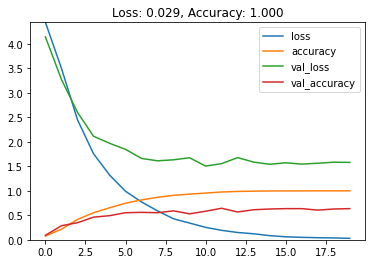

In [ ]:
plot_loss_accuracy(history)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

The final exercise for everyone is to try find a group of settings that works the best for them!

There is a script [here ](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) that compares a bunch of different classifiers  see if you can find a network / classifier combination that works better then the what I have here.

